In [73]:
import numpy as np
import pandas as pd
import nn
import matplotlib.pyplot as plt

In [74]:
model_cfg = {
    "batch_size_p" : 0.1,
    "n_epochs" : 500,
    "verbose" : False,
    "n_input" : 4,
    "n_hidden" : 10,
    "n_output" : 3,
    "hidden_activation" : "relu",
    "stochastic" : True,
    "dropout_p" : 0.1,
    "epsilon" : 0.00,
    "n_samples" : 100
}

# load data 
df = pd.read_csv('iso.csv')
#df = df[df['r1_charge_heater'] >= 0]

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])

model = nn.FeedforwardNN(model_cfg)


In [75]:
ix = (X[:,1] >= 128) & (X[:,2] == 50) & (X[:,3] == 50)
Xtrain = X[ix,:]
Ytrain = Y[ix,:]

In [76]:
model.train(Xtrain, Ytrain)

2022-01-03 11:35:14.442183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [77]:
Xstar = np.array([ [r1t, 128, 50, 50] for r1t in np.linspace(120, 170, 1000)])
preds = model.predict(Xstar, model_cfg['n_samples'])

2022-01-03 11:35:56.883379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [50]:
import scipy.stats as stats

a, b = stats.norm.interval(0.95, np.mean(preds, axis=0), np.std(preds, axis=0))

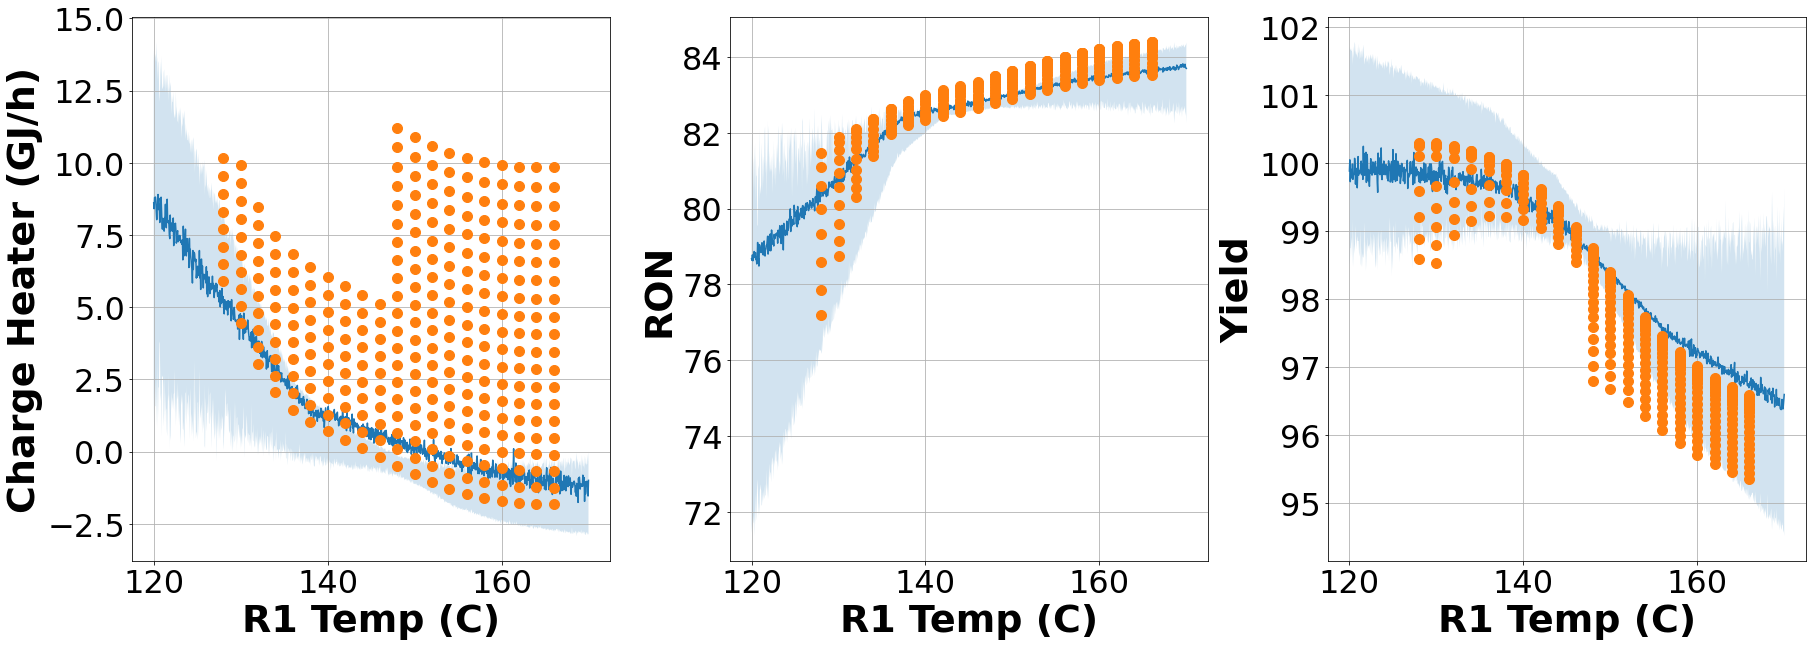

In [78]:
r1temps = np.linspace(120, 170, 1000)

f, axes = plt.subplots(1, 3, figsize=(30, 10))

mu = np.mean(preds, axis=0)

ax = axes[0]
ax.plot(r1temps, mu[:, 0] / 1e6, '-')
ax.fill_between(r1temps, a[:,0]/1e6, b[:,0]/1e6, alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,0] / 1e6, 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Charge Heater (GJ/h)', fontsize=38, fontweight='bold')
ax.grid(True)

ax = axes[1]
ax.plot(r1temps, mu[:, 1], '-')
ax.fill_between(r1temps, a[:,1], b[:,1], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,1], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('RON', fontsize=38, fontweight='bold')
ax.grid(True)

ax = axes[2]
ax.plot(r1temps, mu[:, 2], '-')
ax.fill_between(r1temps, a[:,2], b[:,2], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,2], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Yield', fontsize=38, fontweight='bold')
ax.grid(True)

plt.subplots_adjust(wspace=0.25)

#plt.savefig('tmp/fig9.5.tiff', bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})
